In [232]:
library(ggplot2)
#library(ggExtra)
library(tidyr)
library(dplyr)
library(glue)
library(stringr)
library(seqinr)
library(scales)

### Data aggregation

#### Real data prediction

In [2]:
calculated_keys = read.csv(file = '../dataset/knownpdb/muts_with_answers.txt', sep='\t', stringsAsFactors=F, header = F) %>%
    separate(V1, c('PDB', 'POS', 'WT', 'MUT'), sep = "[-]+", remove = T) %>%
    distinct()

In [3]:
paths = glue('../SDM2/work/known/{1:length(calculated_keys$PDB)-1}_{calculated_keys$PDB}_{calculated_keys$POS}_{calculated_keys$WT}_{calculated_keys$MUT}/{calculated_keys$PDB}_results/')
paths = lapply(paths, function(i) paste0(i, dir(i, pattern='*.csv')))
paths = paths[str_length(paths) > 60]

In [4]:
raw.SDM.table <- do.call(rbind,lapply(paths, read.csv, sep=',', header=T, stringsAsFactors=FALSE))
#head(raw.table)
#print(raw.table)

In [5]:
res.SDM <- raw.SDM.table %>%
    #select(PDB.file, Mutation, Predicted.ddg) %>%
    separate(Mutation, c('WILD', 'MUT'), sep = "[:digit:]+", remove = FALSE) %>%
    mutate(Mutation = gsub("[^0-9.-]", "", Mutation)) %>% 
    extract(PDB.file, c('PDB'), '(....).pdb') %>%
    rename(WT = WILD, POS = Mutation, PRED_DDG = Predicted.ddg) %>%
    mutate(WT = gsub('J', 'C', WT), MUT = gsub('J', 'C', MUT)) %>%
    arrange(PDB, as.numeric(POS), WT, MUT) %>%
    unite(key, c('PDB', 'WT', 'POS', 'MUT'), remove = F)
saveRDS(res.SDM, file="res.SDM.rds")

In [144]:
get_opt_sdm <- function(sdm, rsa){
    opt_sdm = sdm
    
    if (sdm <= -0.915){
        opt_sdm =  0.2722*sdm + 0.0154*rsa - 1.4323
    }
    if (sdm > -0.915){
        if (rsa <= 42.15){
                if (sdm <= 0.515){
                    opt_sdm = 0.0178*sdm + 0.0001*rsa - 1.0598
                }
                if (sdm > 0.515){
                    if(rsa <= 2.7){
                        if(rsa <= 0.95){
                            opt_sdm = 0.0969*sdm + 0.1263*rsa - 0.5924
                        }
                        if(rsa > 0.95){
                            opt_sdm = 0.5593*sdm + 0.2183*rsa - 0.7658
                        }
                    }
                    if(rsa > 2.7){
                        if(sdm <= 1.955){
                            opt_sdm = 0.0485*sdm + 0.0166*rsa - 1.2056
                        }
                        if(sdm > 1.955){
                            opt_sdm =  0.0678*sdm + 0.0023*rsa - 0.4887
                        }
                    }
                }
        }
        if(rsa > 42.15){
            opt_sdm = 0.1839*sdm + 0.0089*rsa - 0.9346
        }
    }

    return(opt_sdm)
}

In [7]:
paths = glue('../mCSM/known/')
paths = sapply(paths, function(i) paste0(i, dir(i, pattern='*.csv')))
#paths = paths[str_length(paths) > 60]

In [8]:
raw.mCSM.table <- do.call(rbind,lapply(paths, read.csv, sep='\t', header=T, stringsAsFactors=FALSE,
                                       colClasses = c(rep("character", 3), "numeric", "character", rep("numeric", 2))))
#print(raw.mCSM.table)
res.mCSM <- raw.mCSM.table %>%
    select(PDB_FILE, WILD_RES, RES_POS, MUT_RES, PRED_DDG) %>%
    rename(WT = WILD_RES, POS = RES_POS, PDB = PDB_FILE, MUT = MUT_RES) %>%
    extract(PDB, c('PDB'), '(....).pdb') %>%
    arrange(PDB, as.numeric(POS), WT, MUT) %>%
    unite(key, c('PDB', 'WT', 'POS', 'MUT'), remove = F)

saveRDS(res.mCSM, file="res.mCSM.rds")

In [168]:
paths = glue('../MAESTRO_linux_x64/work/known/')
paths = sapply(paths, function(i) paste0(i, dir(i, pattern='*.csv')))

In [169]:
raw.MAESTRO.table <- do.call(rbind,lapply(paths, function(i)
    read.table(i, sep='\t', header=F, stringsAsFactors=FALSE, row.names=NULL)[1:7]))
colnames(raw.MAESTRO.table) <- c('structure', 'seqlength', 'mutation', 'score', 'delta_score', 'ddG', 'ddG_confidence')

In [170]:
res.MAESTRO <- raw.MAESTRO.table %>%
    select(structure, mutation, ddG) %>%
    extract(structure, c("chain"), ",(.),", remove = F) %>%
    extract(structure, c("structure"), "knownpdb/(....)", remove = T) %>%
    extract(mutation, c("WT", "POS", "MUT"), "(.)(\\d+)..\\{(.)\\}") %>%
    rename(PDB = structure, PRED_DDG = ddG) %>%
    arrange(PDB, as.numeric(POS), WT, MUT) %>%
    unite(key, c('PDB', 'WT', 'POS', 'MUT'), remove = F)
    #separate(mutation, c('WILD_RES', 'MUT_RES'), sep = "[:digit:]+", remove = FALSE) %>%
dim(res.MAESTRO) 

saveRDS(res.MAESTRO, file="res.MAESTRO.rds")

[1] 1332    7

In [12]:
paths = glue('../MuPro/workdir/res/')
paths = sapply(paths, function(i) paste0(i, dir(i, pattern='*.dat')))

In [13]:
files = lapply(paths, read.csv, sep='\t', header=T, stringsAsFactors=FALSE)
#print(length(files))
paths = paths[sapply(files, nrow) == 1]
files = files[sapply(files, nrow) == 1]
#print(length(files))
rownames(paths) <- NULL
files = sapply(files, function(i) i[1])
raw.MuPro.table <- as.vector(do.call(rbind, files))
names(raw.MuPro.table) <- NULL
#print(length(paths))

In [14]:
res.MuPro = cbind(paths, raw.MuPro.table)
res.MuPro = as.data.frame(res.MuPro) %>%
    extract(raw.MuPro.table, c("PRED_DDG"), "(-*\\d+.\\d+)") %>%
    extract(paths, c('PDB', 'POS', 'WT', 'MUT'), '/\\d+_(....)_(\\d+)_(.)_(.).dat') %>%
    arrange(PDB, as.numeric(POS), WT, MUT) %>%
    unite(key, c('PDB', 'WT', 'POS', 'MUT'), remove = F)

saveRDS(res.MuPro, file="res.MuPro.rds")

In [15]:
paths = '../CUPSAT/known/'
paths = sapply(paths, function(i) paste0(i, dir(i, pattern='*csv')))

In [16]:
#mut_keys = unite(res.SDM, key, c('PDB', 'WT', 'POS', 'MUT'))$key

In [222]:
real.table = read.csv(file = '../dataset/full_dataset.csv', sep='\t') %>%
    select(PDB.ID.with.modifications.to.be.made, Mutation, ddG..kcal.mol..positive.is.stable, pH, 'T') %>%
    rename(PDB = PDB.ID.with.modifications.to.be.made, DDG = ddG..kcal.mol..positive.is.stable) %>%
    group_by(PDB, Mutation) %>%
    summarise_at('DDG', funs(mean)) %>%
    separate(Mutation, c('WT', 'POS', 'MUT')) %>%
    arrange(PDB, as.numeric(POS), WT, MUT) %>%
    unite(key, c('PDB', 'WT', 'POS', 'MUT'))

saveRDS(real.table, file="res.real.table.rds")
    
#y_val = subset(real.table, real.table$key %in% mut_keys)$DDG

In [196]:
paths = glue('../CUPSAT/known/')
paths = sapply(paths, function(i) paste0(i, dir(i, pattern='*.csv')))

In [204]:
list_of_csv = list()
for(i in 1:nrow(paths)){
    #read.csv(paths[i], sep=';')
    try({
        tmp = read.csv(paths[i], sep=';')
        pdb = toupper(unlist(strsplit(paths[i], split = '_'))[3])
        df <- subset(tmp, as.numeric(tmp$Residue.ID) %in% unique(subset(res.MAESTRO, res.MAESTRO$PDB == pdb)$POS))
        df$PDB <- pdb
        df <- subset(df, df$Chain %in% unique(res.MAESTRO$chain[res.MAESTRO$PDB == pdb]))
        colnames(df) <- c('Chain', 'WT', 'POS', 'MUT', 'stab', 'angle', 'PRED_DDG', 'PDB')
        list_of_csv[[i]] <- df
        })
}

 raw.CUPSAT.table <- do.call(rbind, list_of_csv)

Warning message in `[<-.factor`(`*tmp*`, ri, value = c(2L, 2L, 2L, 2L, 2L, 2L, 2L, :
“invalid factor level, NA generated”

In [206]:
dim(raw.CUPSAT.table)

[1] 20045     8

In [221]:
res.CUPSAT <- raw.CUPSAT.table %>%
    select(PDB, Chain, WT, POS, MUT, PRED_DDG) %>%
    mutate(WT = a(firstup(WT)), MUT = a(firstup(MUT)))  %>%
    arrange(PDB, as.numeric(POS), WT, MUT) %>%
    unite(key, c('PDB', 'WT', 'POS', 'MUT'), remove = F) %>%
    distinct()

res.CUPSAT <- subset(res.CUPSAT, res.CUPSAT$key %in% res.MAESTRO$key)
saveRDS(res.CUPSAT, file="res.CUPSAT.rds")
dim(res.CUPSAT)

[1] 1268    7

#### Full dataset for SDM

In [223]:
calculated_keys = read.csv(file = '../dataset/knownpdb/full_muts_with_answers.txt', sep='\t', stringsAsFactors=F, header = F) %>%
    separate(V1, c('PDB', 'POS', 'WT', 'MUT'), sep = "[-]+", remove = T) %>%
    distinct()

paths = glue('../SDM2/work/full_known/{1:length(calculated_keys$PDB)-1}_{calculated_keys$PDB}_{calculated_keys$POS}_{calculated_keys$WT}_{calculated_keys$MUT}/{calculated_keys$PDB}_results/')
paths = lapply(paths, function(i) paste0(i, dir(i, pattern='*.csv')))
paths = paths[str_length(paths) > 60]
               
raw.SDM.table <- do.call(rbind,lapply(paths, read.csv, sep=',', header=T, stringsAsFactors=FALSE))

In [224]:
res.full.SDM <- raw.SDM.table %>%
    #select(PDB.file, Mutation, Predicted.ddg) %>%
    separate(Mutation, c('WILD', 'MUT'), sep = "[:digit:]+", remove = FALSE) %>%
    mutate(Mutation = gsub("[^0-9.-]", "", Mutation)) %>% 
    extract(PDB.file, c('PDB'), '(....).pdb') %>%
    rename(WT = WILD, POS = Mutation, PRED_DDG = Predicted.ddg) %>%
    mutate(WT = gsub('J', 'C', WT), MUT = gsub('J', 'C', MUT)) %>%
    arrange(PDB, as.numeric(POS), WT, MUT) %>%
    unite(key, c('PDB', 'WT', 'POS', 'MUT'), remove = F)

saveRDS(res.full.SDM, file="res.full.SDM.rds")

In [225]:
dim(res.full.SDM)

[1] 4290   22

In [231]:
subset(res.full.SDM, res.full.SDM$WT_SSE == 'l')

,key,PDB,Chain.ID,POS,WT,MUT,WT_SSE,WT_RSA...,WT_DEPTH..angstrom.,WT_OSP,⋯,WT_SO,MT_SSE,MT_RSA...,MT_DEPTH..angstrom.,MT_OSP,MT_SS,MT_SN,MT_SO,PRED_DDG,Outcome
109,1AM7_H_31_D,1AM7,A,31,H,D,l,75.7,3.41,0.246,⋯,0,g,68.2,3.55,0.313,0,0,0,-0.39,Reduced stability
117,1AMQ_C_192_A,1AMQ,A,192,C,A,l,2.4,9.56,0.509,⋯,0,l,4.3,9.86,0.430,0,0,0,-1.05,Reduced stability
207,1ARR_R_50_A,1ARR,A,50,R,A,l,93.0,3.31,0.110,⋯,0,l,81.2,3.27,0.213,0,0,0,0.34,Increased stability
249,1BLC_D_179_N,1BLC,A,179,D,N,l,0.7,7.46,0.557,⋯,0,l,0.9,7.98,0.584,1,1,0,0.21,Increased stability
286,1BNI_H_18_A,1BNI,A,18,H,A,l,61.1,3.54,0.311,⋯,1,l,59.7,3.19,0.337,0,0,0,-0.05,Reduced stability
287,1BNI_H_18_D,1BNI,A,18,H,D,l,61.1,3.54,0.311,⋯,1,l,75.6,3.33,0.276,0,0,0,-0.78,Reduced stability
288,1BNI_H_18_G,1BNI,A,18,H,G,l,61.1,3.54,0.311,⋯,1,l,52.4,3.59,0.394,0,0,0,1.13,Increased stability
289,1BNI_H_18_K,1BNI,A,18,H,K,l,61.1,3.54,0.311,⋯,1,l,73.3,3.43,0.231,0,0,0,-0.63,Reduced stability
290,1BNI_H_18_N,1BNI,A,18,H,N,l,61.1,3.54,0.311,⋯,1,l,70.9,3.51,0.307,1,0,0,-0.45,Reduced stability
291,1BNI_H_18_Q,1BNI,A,18,H,Q,l,61.1,3.54,0.311,⋯,1,l,74.6,3.47,0.242,0,0,0,-0.27,Reduced stability


In [ ]:
subset(res.full.SDM)

#### Artificail dataset

In [179]:
calculated_keys = read.csv(file = '../dataset/readypdb/readypdb.txt', sep='\t', stringsAsFactors=F, header = F) %>%
    separate(V1, c('PDB', 'POS', 'WT', 'MUT'), sep = "[-]+", remove = T) %>%
    distinct()

paths = glue('../SDM2/work/ready/{1:length(calculated_keys$PDB)-1}_{calculated_keys$PDB}_{calculated_keys$POS}_{calculated_keys$WT}_{calculated_keys$MUT}/{calculated_keys$PDB}_results/')
paths = lapply(paths, function(i) paste0(i, dir(i, pattern='*.csv')))
paths = paths[str_length(paths) > 60]
               
raw.ready.SDM.table <- do.call(rbind,lapply(paths, read.csv, sep=',', header=T, stringsAsFactors=FALSE))

In [180]:
res.ready.SDM <- raw.ready.SDM.table %>%
    #select(PDB.file, Mutation, Predicted.ddg) %>%
    separate(Mutation, c('WILD', 'MUT'), sep = "[:digit:]+", remove = FALSE) %>%
    mutate(Mutation = gsub("[^0-9.-]", "", Mutation)) %>% 
    extract(PDB.file, c('PDB'), '(....).pdb') %>%
    rename(WT = WILD, POS = Mutation, PRED_DDG = Predicted.ddg) %>%
    mutate(WT = gsub('J', 'C', WT), MUT = gsub('J', 'C', MUT)) %>%
    arrange(PDB, as.numeric(POS), WT, MUT) %>%
    unite(key, c('PDB', 'WT', 'POS', 'MUT'), remove = F)


print(dim(res.ready.SDM))
saveRDS(res.ready.SDM, file="res.ready.SDM.rds")

[1] 43318    22


In [12]:
paths = glue('../mCSM/ready/')
paths = sapply(paths, function(i) paste0(i, dir(i, pattern='*.csv')))
#paths = paths[str_length(paths) > 60]

In [13]:
raw.mCSM.table <- do.call(rbind,lapply(paths, read.csv, sep='\t', header=T, stringsAsFactors=FALSE,
                                       colClasses = c(rep("character", 3), "numeric", "character", rep("numeric", 2))))
#print(raw.mCSM.table)
res.ready.mCSM <- raw.mCSM.table %>%
    select(PDB_FILE, WILD_RES, RES_POS, MUT_RES, PRED_DDG) %>%
    rename(WT = WILD_RES, POS = RES_POS, PDB = PDB_FILE, MUT = MUT_RES) %>%
    extract(PDB, c('PDB'), '(....).pdb') %>%
    arrange(PDB, as.numeric(POS), WT, MUT) %>%
    unite(key, c('PDB', 'WT', 'POS', 'MUT'), remove = F)

saveRDS(res.ready.mCSM, file="res.ready.mCSM.rds")

In [121]:
paths = glue('../MAESTRO_linux_x64/work/ready/')
paths = sapply(paths, function(i) paste0(i, dir(i, pattern='*.csv')))

In [122]:
raw.MAESTRO.table <- do.call(rbind,lapply(paths, function(i)
    read.table(i, sep='\t', header=F, stringsAsFactors=FALSE, row.names=NULL)[1:7]))
colnames(raw.MAESTRO.table) <- c('structure', 'seqlength', 'mutation', 'score', 'delta_score', 'ddG', 'ddG_confidence')

In [129]:
res.ready.MAESTRO <- raw.MAESTRO.table %>%
    select(structure, mutation, ddG) %>%
    extract(structure, c("chain"), ",(.),", remove = F) %>%
    extract(structure, c("structure"), "readypdb/(....)", remove = T) %>%
    extract(mutation, c("WT", "POS", "MUT"), "(.)(\\d+)..\\{(.)\\}") %>%
    rename(PDB = structure, PRED_DDG = ddG) %>%
    arrange(PDB, as.numeric(POS), WT, MUT) %>%
    unite(key, c('PDB', 'WT', 'POS', 'MUT'), remove = F)
    #separate(mutation, c('WILD_RES', 'MUT_RES'), sep = "[:digit:]+", remove = FALSE) %>%
print(dim(res.ready.MAESTRO) )

saveRDS(res.ready.MAESTRO, file="res.ready.MAESTRO.rds")

[1] 43700     7


In [131]:
paths = glue('../CUPSAT/ready/')
paths = sapply(paths, function(i) paste0(i, dir(i, pattern='*.csv')))

In [132]:
head(read.csv(paths[1], sep=';'))

Chain,Wild.type.AA,Residue.ID,Amino.acid,Overall.Stability,Torsion,Predicted.DDG..kcal.mol.
1,GLU,6,GLY,Destabilising,Unfavourable,-0.10
1,GLU,6,ALA,Stabilising,Unfavourable,1.50
1,GLU,6,VAL,Stabilising,Unfavourable,2.66
1,GLU,6,LEU,Stabilising,Unfavourable,3.87
1,GLU,6,ILE,Stabilising,Unfavourable,4.34
1,GLU,6,MET,Stabilising,Favourable,3.03


In [133]:
list_of_csv = list()
for(i in 1:nrow(paths)){
    #read.csv(paths[i], sep=';')
    tmp = read.csv(paths[i], sep=';')
    pdb = toupper(unlist(strsplit(paths[i], split = '_'))[3])
    df <- subset(tmp, as.numeric(tmp$Residue.ID) %in% unique(subset(res.ready.mCSM, res.ready.mCSM$PDB == pdb)$POS))
    df$PDB <- pdb
    df <- subset(df, df$Chain %in% unique(res.ready.MAESTRO$chain[res.ready.MAESTRO$PDB == pdb]))
    colnames(df) <- c('Chain', 'WT', 'POS', 'MUT', 'stab', 'angle', 'PRED_DDG', 'PDB')
    list_of_csv[[i]] <- df
}

 raw.CUPSAT.table <- do.call(rbind, list_of_csv)

In [134]:
head(raw.CUPSAT.table)

,Chain,WT,POS,MUT,stab,angle,PRED_DDG,PDB
21946,B,MET,1,GLY,Destabilising,Favourable,-4.52,1AL0
21947,B,MET,1,ALA,Destabilising,Unfavourable,-2.36,1AL0
21948,B,MET,1,VAL,Destabilising,Unfavourable,-1.11,1AL0
21949,B,MET,1,LEU,Destabilising,Favourable,-1.94,1AL0
21950,B,MET,1,ILE,Destabilising,Favourable,-2.91,1AL0
21951,B,MET,1,PRO,Destabilising,Unfavourable,-2.32,1AL0


In [198]:
firstup <- function(x) {
  x <- tolower(x)
  substr(x, 1, 1) <- toupper(substr(x, 1, 1))
  x
}

In [138]:
res.ready.CUPSAT <- raw.CUPSAT.table %>%
    select(PDB, Chain, WT, POS, MUT, PRED_DDG) %>%
    mutate(WT = a(firstup(WT)), MUT = a(firstup(MUT)))  %>%
    arrange(PDB, as.numeric(POS), WT, MUT) %>%
    unite(key, c('PDB', 'WT', 'POS', 'MUT'), remove = F) %>%
    distinct()

res.ready.CUPSAT <- subset(res.ready.CUPSAT, res.ready.CUPSAT$key %in% res.ready.mCSM$key)

In [139]:
saveRDS(res.ready.CUPSAT, file="res.ready.CUPSAT.rds")

### Load dataframes

In [177]:
res.SDM <- readRDS(file="res.SDM.rds")
res.mCSM <- readRDS(file="res.mCSM.rds")
res.MAESTRO <- readRDS(file="res.MAESTRO.rds")
res.MuPro <- readRDS(file="res.MuPro.rds")

real.table <- readRDS(file="real.table.rds")
res.full.SDM <- readRDS(file="res.full.SDM.rds")

res.ready.SDM <- readRDS(file="res.ready.SDM.rds")
res.ready.mCSM <- readRDS(file="res.ready.mCSM.rds")
res.ready.MASETRO <- readRDS(file="res.ready.MAESTRO.rds")
res.ready.CUPSAT <- readRDS(file="res.ready.CUPSAT.rds")

[1] 983   6

## Part I

In [27]:
#aggr = cbind(res.SDM$PRED_DDG, -res.MAESTRO$PRED_DDG, res.mCSM$PRED_DDG)
#colnames(aggr) = c('SDM', 'MAESTRO', 'mCSM')
#boxplot(aggr)
cor(as.numeric(subset(res.MuPro, res.MuPro$key %in% res.SDM$key)$PRED_DDG), subset(real.table, real.table$key %in% res.MuPro$key & real.table$key %in% res.SDM$key)$DDG)
cor(subset(res.SDM, res.SDM$key %in% res.MuPro$key)$PRED_DDG, subset(real.table, real.table$key %in% res.MuPro$key & real.table$key %in% res.SDM$key)$DDG)
#cor(subset(res.SDM2, res.SDM2$key %in% res.MuPro$key)$PRED_DDG, subset(real.table, real.table$key %in% res.MuPro$key & real.table$key %in% res.SDM2$key)$DDG)
cor(subset(res.mCSM, res.mCSM$key %in% res.MuPro$key)$PRED_DDG, subset(real.table, real.table$key %in% res.MuPro$key & real.table$key %in% res.mCSM$key)$DDG)
-cor(subset(res.MAESTRO, res.MAESTRO$key %in% res.MuPro$key)$PRED_DDG, subset(real.table, real.table$key %in% res.MuPro$key & real.table$key %in% res.MAESTRO$key)$DDG)

#cor(res.mCSM$PRED_DDG, y_val)
#cor(-res.MAESTRO$PRED_DDG, y_val)

[1] 0.3816605

[1] 0.4898656

[1] 0.5478027

[1] 0.5665372

[1] 0.5001267

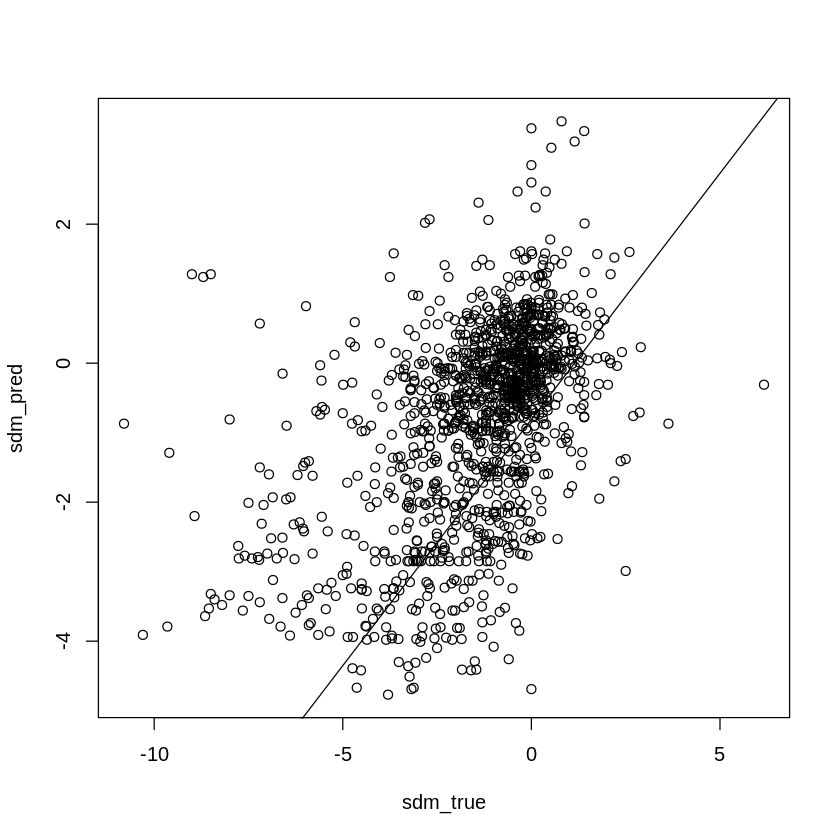

In [28]:
sdm_pred = subset(res.SDM)$PRED_DDG
sdm_true = subset(real.table,real.table$key %in% res.SDM$key)$DDG

plot(sdm_true, sdm_pred)
abline(lm(sdm_true ~ sdm_pred), 'red')
cor(sdm_true, sdm_pred)

## Part II

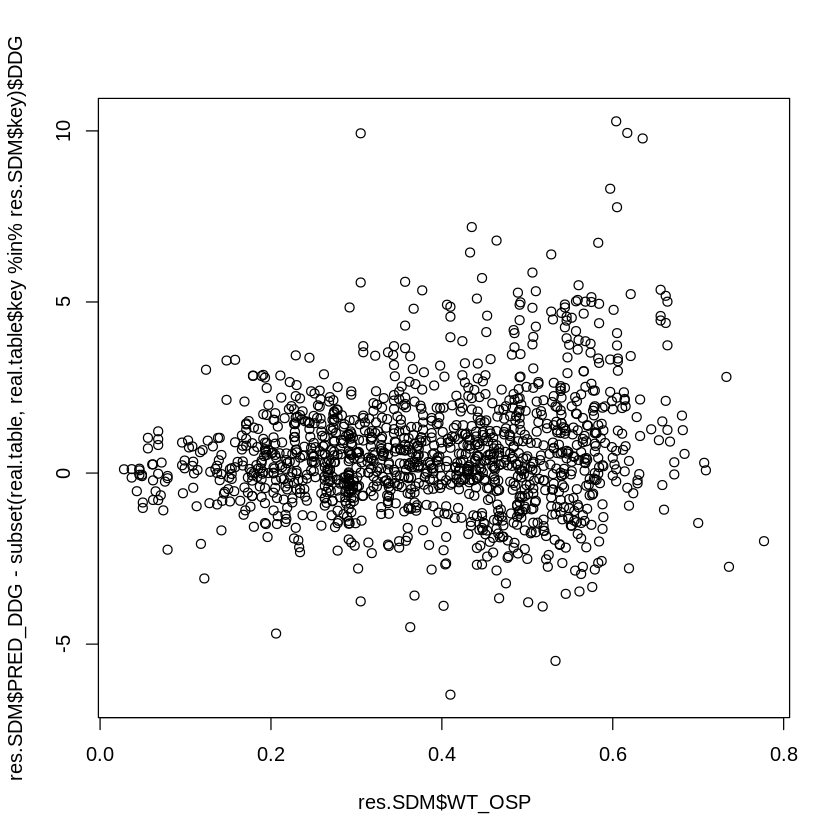

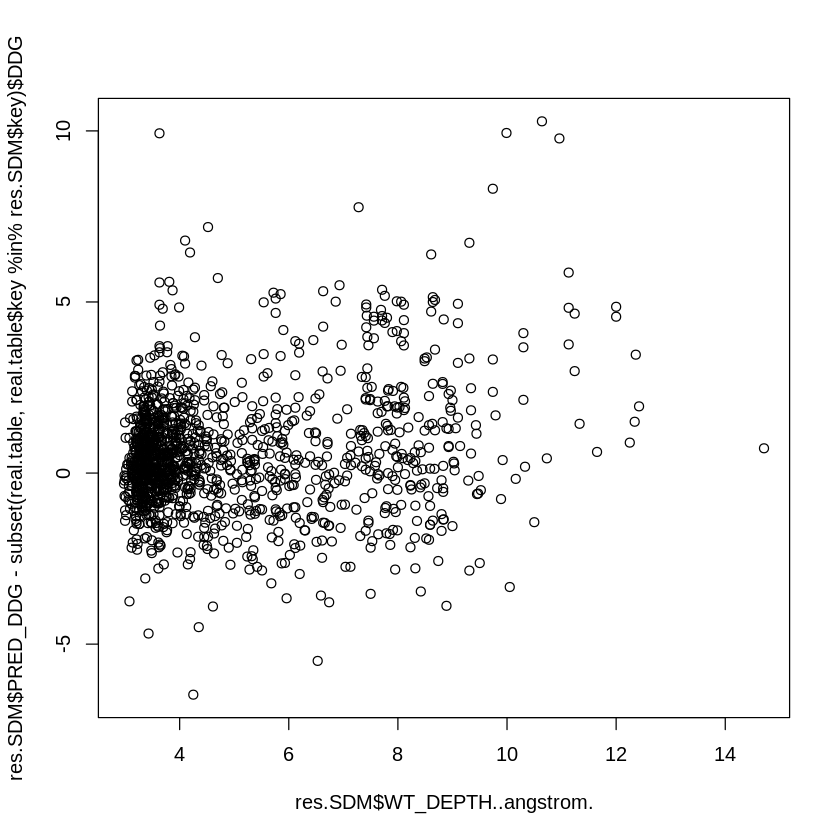

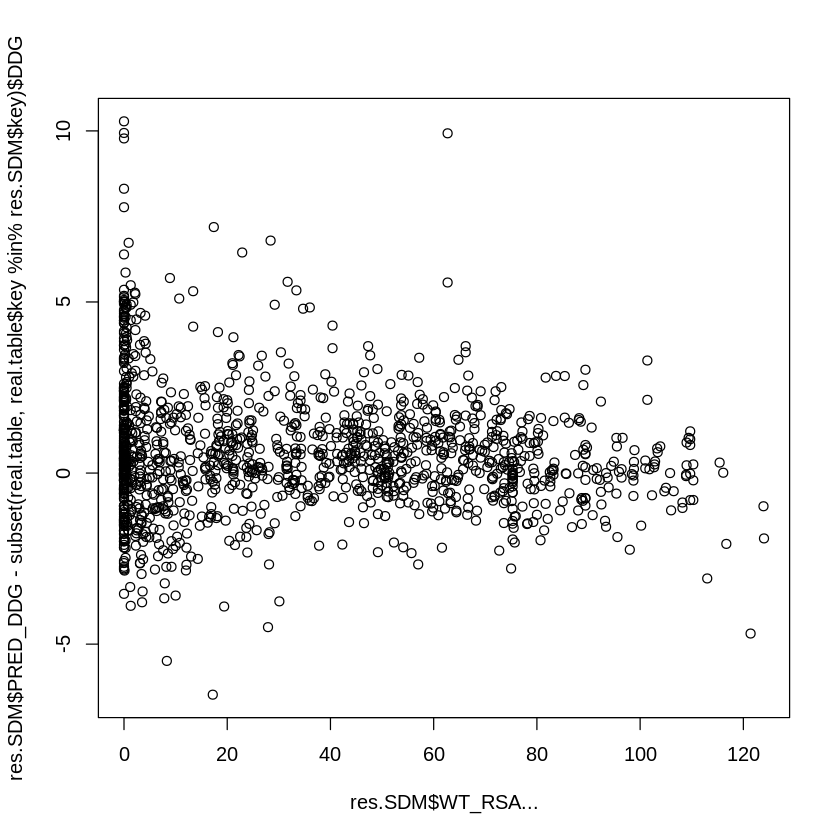

In [29]:
plot(res.SDM$WT_OSP, res.SDM$PRED_DDG - subset(real.table, real.table$key %in% res.SDM$key)$DDG)

plot(res.SDM$WT_DEPTH..angstrom., res.SDM$PRED_DDG - subset(real.table, real.table$key %in% res.SDM$key)$DDG)

plot(res.SDM$WT_RSA..., res.SDM$PRED_DDG - subset(real.table, real.table$key %in% res.SDM$key)$DDG)

## Part III

## Sandbox

In [208]:
muts = read.csv(paths[1], sep = ';', header = F)
muts$PDB = paths[1]
extract(muts, c("PDB"), c("PDB"), "readypdb/(....)")

V1,V2,V3,PDB
Y,91,A,1AL0
Y,91,C,1AL0
Y,91,D,1AL0
Y,91,E,1AL0
Y,91,F,1AL0
Y,91,G,1AL0
Y,91,H,1AL0
Y,91,I,1AL0
Y,91,K,1AL0
Y,91,L,1AL0


In [226]:
mut.list = do.call(rbind, lapply(paths, function(i){
    muts = read.csv(i, sep = ';', header = F)
    colnames(muts) = c('WT', 'POS', 'MUT')
    muts$PDB = i
    muts <- extract(muts, c("PDB"), c("PDB"), "readypdb/(....)")
    muts <- muts[,c("PDB", "POS", "WT", "MUT")]
    unite(muts, c("PDB", "POS", "WT", "MUT"), sep = '-')
}))


In [232]:
write(unlist(mut.list), file="../dataset/readypdb/readypdb.txt")

Warning message in install.packages("matrixStats"):
“installation of package ‘matrixStats’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [ ]:
### R plotting

ERROR: Error in library(matrixStats): there is no package called ‘matrixStats’


In [234]:
con = file('./monomer.ss', "r")
ss = readLines(con)
print(ss)
close(con)

ss = strsplit(ss, split='')[[1]]

df.ss <- data.frame(RES_POS = 1:length(ss), ss = ss)

Warning message in readLines(con):
“incomplete final line found on './monomer.ss'”

[1] "LLSSSSSSSSLLLLLLHHHHHHHHHHLLLLLLLLLLLLLSSSSSSSSLLSSSSSSSSLLLLLHHHHHHHHHHHLLLLSSSSSSSLLLHHHHHHHHHHHHHHHHHHLLLLLSSSSSSLHHHHHLHHHHHHLLLLLLLHHHHHHHLLLSSSSLLLLLLLLHHHHHHHHHHHHLLLLLLLLLLLLLLLLLLLLL"


In [262]:
df.mCSM$PRED_DDG

[1] -1.228 -0.241  0.270  0.243  0.092 -0.201 -0.107  0.146 -0.517 -0.886
[11] -2.079 -0.584 -0.491 -0.776 -0.090 -1.174  0.230 -0.544 -0.042 -1.076
[21] -0.615 -1.229 -0.282 -0.877 -0.895 -0.448  0.217 -0.170 -0.933  0.166
[31]  0.170 -0.187 -1.273 -0.769 -1.112  0.292  0.122 -0.065 -1.568  0.057
[41]  0.266  0.331 -0.390 -0.225 -1.019

In [344]:
raw.table = read.csv(file = './monomer_mCSM.csv', sep='\t', stringsAsFactors=FALSE)

df.mCSM <- raw.table %>%
    select(-PDB_FILE, -RSA) %>%
    group_by(RES_POS, MUT_RES) %>%
    mutate(POS_FREQ = n()) %>% 
    distinct() %>%
    arrange(as.numeric(RES_POS), MUT_RES)

file_names <- dir('./SDM/', pattern = '*.csv') 
raw.table <- do.call(rbind,lapply(paste0('./SDM/',file_names), read.csv, sep=',', header=T))

df.SDM <- raw.table %>%
    select(Mutation, Predicted.ddg) %>%
    separate(Mutation, c('WILD_RES', 'MUT_RES'), sep = "[:digit:]+", remove = FALSE) %>%
    mutate(Mutation = gsub("[^0-9.-]", "", Mutation)) %>% 
    rename(RES_POS = Mutation, PRED_DDG = Predicted.ddg) %>%
    mutate(WILD_RES = gsub('J', 'C', WILD_RES), MUT_RES = gsub('J', 'C', MUT_RES)) %>%
    arrange(as.numeric(RES_POS), MUT_RES) %>%
    mutate(POS_FREQ = df.mCSM$POS_FREQ)

raw.table = read.csv(file = './monomer_MAESTRO.csv', sep=';', stringsAsFactors=FALSE)

df.MAESTRO <- raw.table %>%
    select(substitution, ddG_pred) %>%
    extract(substitution, c("chain"), ".(.)\\{", remove = F) %>%
    extract(substitution, c("WILD_RES", "RES_POS", "MUT_RES"), "(.)(\\d+)..\\{(.)\\}") %>%
    arrange(as.numeric(RES_POS), MUT_RES) %>%
    distinct() %>%
    arrange(as.numeric(RES_POS), MUT_RES) %>%
    mutate(POS_FREQ = df.mCSM$POS_FREQ) %>%
    mutate(ddG_pred = -as.numeric(ddG_pred))

df.Total <- df.SDM %>%
    rename(S_PRED_DDG = PRED_DDG) %>%
    mutate(m_PRED_DDG = as.numeric(df.mCSM$PRED_DDG), M_PRED_DDG = as.numeric(df.MAESTRO$ddG_pred)) %>%
    rowwise() %>%
             do(data.frame(., MEAN_PRED_DDG=mean(as.numeric(unlist(.[c('S_PRED_DDG', 'm_PRED_DDG', 'M_PRED_DDG')]))),
                         STD_PRED_DDG=sd(as.numeric(unlist(.[c('S_PRED_DDG', 'm_PRED_DDG', 'M_PRED_DDG')]))))) %>%
    gather(`S_PRED_DDG`, `m_PRED_DDG`, `M_PRED_DDG`, key = "method", value = "PRED_DDG")

df.Total

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into charac

“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”Warning message in bind_rows_(x, .id):
“binding character and facto

RES_POS,WILD_RES,MUT_RES,POS_FREQ,MEAN_PRED_DDG,STD_PRED_DDG,method,PRED_DDG
12,D,N,1,-0.83695812,0.58046389,S_PRED_DDG,-0.17
23,R,C,7,-1.10839595,0.81732875,S_PRED_DDG,-1.22
23,R,H,3,-0.76184142,0.97410574,S_PRED_DDG,-0.89
27,E,K,1,0.22640862,0.26849766,S_PRED_DDG,-0.05
31,E,K,1,0.17899546,0.38984253,S_PRED_DDG,-0.16
32,A,T,1,-0.10066623,0.20032515,S_PRED_DDG,0.13
39,E,K,1,0.14937592,0.22272168,S_PRED_DDG,0.26
49,G,S,1,-1.07762829,2.01220199,S_PRED_DDG,-3.40
53,S,T,1,0.15179971,0.61400685,S_PRED_DDG,0.69
54,L,M,1,-0.87035329,0.23785636,S_PRED_DDG,-1.10


In [309]:
library(repr)

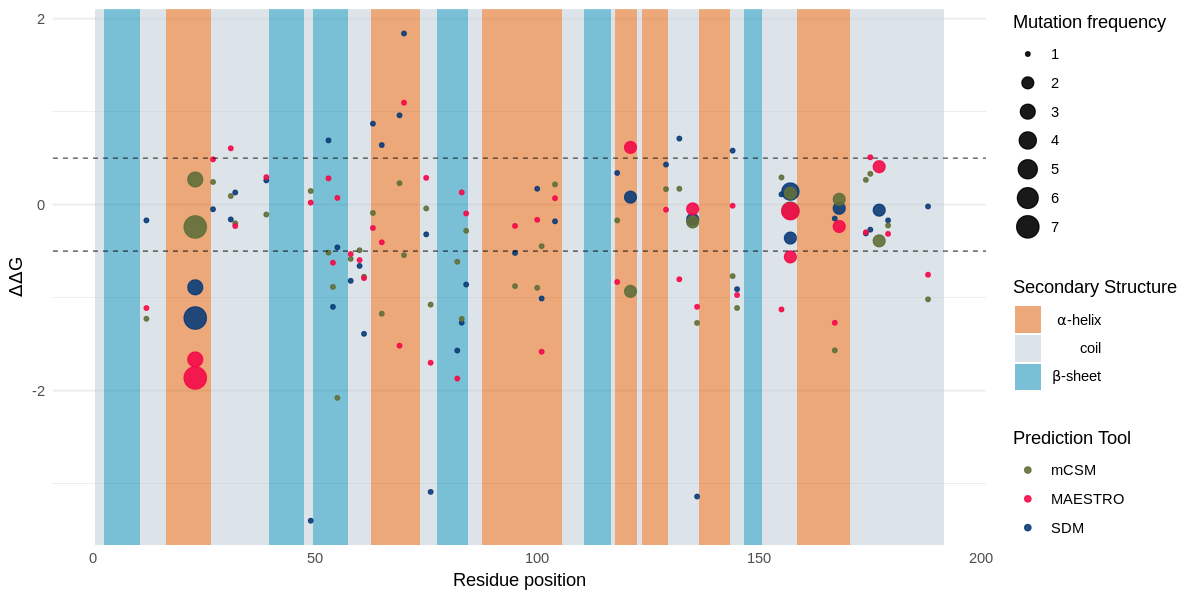

In [408]:
options(repr.plot.width=10, repr.plot.height=5)
ggplot(df.Total) + geom_rect(data=df.ss, aes(xmin=RES_POS-0.5, xmax=RES_POS+0.5, fill=ss, ymin = -Inf, ymax = Inf), alpha = 0.6, colour = NA) +
geom_point(aes(x=as.numeric(RES_POS), y=PRED_DDG, size=POS_FREQ, colour = method), alpha = 0.9) +
#geom_hline(yintercept=0, linetype="dashed", color = "black", size=0.25) + 
geom_hline(yintercept=0.5, linetype="dashed", color = "black", size=0.25) + 
geom_hline(yintercept=-0.5, linetype="dashed", color = "black", size=0.25) + 
xlab("Residue position") + ylab(expression(Delta*Delta*"G")) +

scale_fill_manual(values=c("#DF6E21", "#C5D2DB", "#2096BA"), aesthetics = 'fill', name="Secondary Structure",
                   labels=c(expression(alpha*'-helix'), 'coil', expression(beta*'-sheet')) ) +
scale_colour_manual(values=c("#616f39", "#f30a49", "#0c3c78"), aesthetics = 'colour', name="Prediction Tool",
                   labels=c('mCSM', 'MAESTRO', 'SDM')) +
scale_size(name="Mutation frequency", range = c(1, 6)) +

theme_minimal() +
theme(panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank())


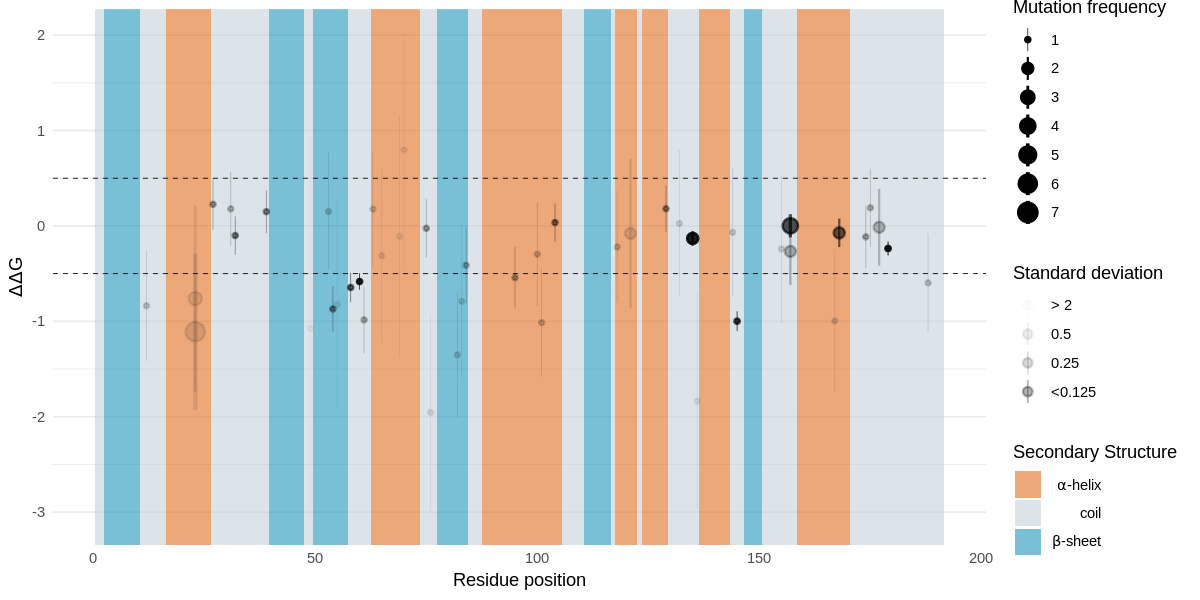

In [411]:
options(repr.plot.width=10, repr.plot.height=5)
ggplot(df.Total) + geom_rect(data=df.ss, aes(xmin=RES_POS-0.5, xmax=RES_POS+0.5, fill=ss, ymin = -Inf, ymax = Inf), alpha = 0.6, colour = NA) +
geom_pointrange(aes(x=as.numeric(RES_POS), y=MEAN_PRED_DDG,
               ymin = MEAN_PRED_DDG - STD_PRED_DDG,
               ymax = MEAN_PRED_DDG + STD_PRED_DDG, alpha = 1/STD_PRED_DDG, size=POS_FREQ)) +
#geom_hline(yintercept=0, linetype="dashed", color = "black", size=0.25) + 
geom_hline(yintercept=0.5, linetype="dashed", color = "black", size=0.25) + 
geom_hline(yintercept=-0.5, linetype="dashed", color = "black", size=0.25) + 
xlab("Residue position") + ylab(expression(Delta*Delta*"G")) +

scale_fill_manual(values=c("#DF6E21", "#C5D2DB", "#2096BA"), aesthetics = 'fill', name="Secondary Structure",
                   labels=c(expression(alpha*'-helix'), 'coil', expression(beta*'-sheet')) ) +
scale_alpha(name='Standard deviation', breaks = c(0.5, 2, 4, 8), labels=c('> 2', '0.5', '0.25', '<0.125'), range=c(0.01,0.5)) +
#scale_alpha(breaks = c(-0.25, -0.5, -1, -2), labels=c('< 0.25', '0.5', '1', '>2')) +
scale_size(name="Mutation frequency", range = c(0.2, 1.2))+
theme_minimal() +
theme(panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank())